In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

#KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads, this fixes it
import os
os.environ["OMP_NUM_THREADS"] = "2"

In [4]:
#we make the spectral clustering function; this can determine structure better than K-means alone

def spectral_clustering(data, n_clusters, n_neighbors):
    #compute weight matrix using k-NN with k=n_neighbors
    W = kneighbors_graph(data, n_neighbors, mode='connectivity', include_self=False).toarray()
    W = 0.5*(W+W.T) #make the weight matrix symmetric
    
    #compute unnormalized Laplacian matrix L
    D = np.diag(W.sum(axis=1)) #degree matrix
    L = D - W
    
    #compute eigenvectors and eigenvalues of Laplacian
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    #select the m eigenvectors associated with the m smallest eigenvalues, where m=n_clusters
    k_smallest_indices = np.argsort(eigenvalues)[:n_clusters]
    
    #create matrix with ith column given by eigenvector with ith smallest eigenvalue
    U = eigenvectors[:, k_smallest_indices]
    
    #finally, perform k-means on the rows of U
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=42)
    kmeans.fit(U)
    clusters = kmeans.labels_
    
    return clusters

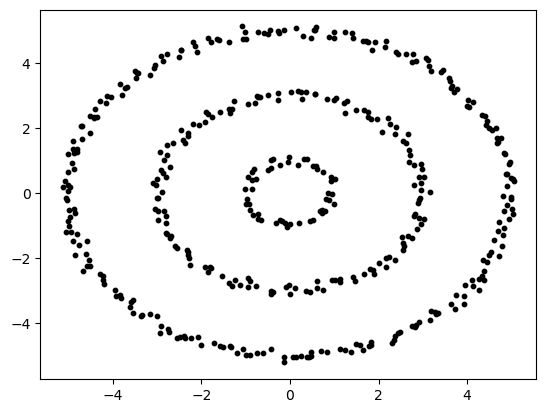

In [5]:
#we create a dataset consisting of concentric circles
circle = lambda x, y, stddev, radius, n_samples: [
    (
        x + radius * math.cos(2 * math.pi * i / n_samples) + np.random.normal(0, stddev),
        y + radius * math.sin(2 * math.pi * i / n_samples) + np.random.normal(0, stddev)
    )
    for i in range(n_samples)
]

circles_dataset = sum((circle(0, 0, 0.1, radius, radius * 50) for radius in [1, 3, 5]), start=[])
plt.scatter(*zip(*circles_dataset), s=10, color='black')
plt.show()

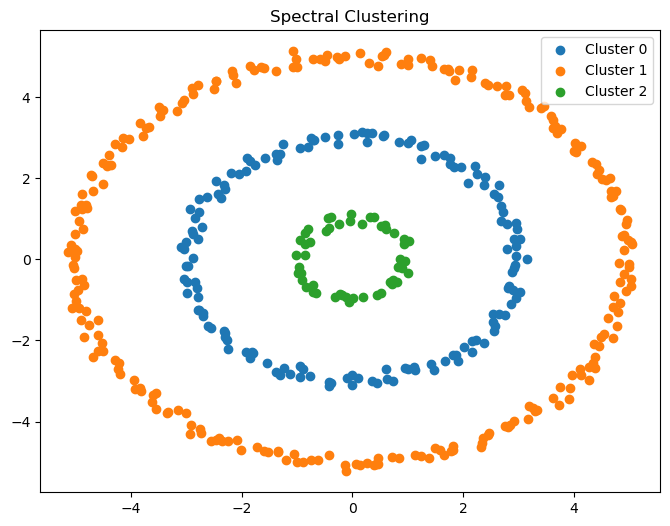

In [6]:
#now we can test our spectral clustering algorithm on the circles dataset
X = circles_dataset
n_clusters = 3
n_neighbors = 5

clusters = spectral_clustering(X, n_clusters, n_neighbors)

#plot the clusters and see how our algorithm performed; it does exactly what we want!
plt.figure(figsize=(8, 6))
X = np.array(X)  #convert X to a NumPy array
for cluster_id in range(n_clusters):
    cluster_points = X[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')
plt.title('Spectral Clustering')
plt.legend()
plt.show()